# Building on David Shean's SNOTEL querying tutorial to generate a table of snow depth differences for SnowEx sites

### TODO: want change in depth and change in swe and max temp; coherence: how confident are we in timing of signal - low means inaccurate phase difference

## Setup and key package imports
***

In [1]:
# This is the latest CUAHSI API endpoint
#http://his.cuahsi.org/wofws.html
wsdlurl = 'http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

#Install directly from github repo main branch
# %pip install -q git+https://github.com/ulmo-dev/ulmo.git # only need to run this the first time you run the notebook

In [2]:
#Despite warning, shouldn't need to restart kernel if all goes well
import ulmo

import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
import contextily as ctx

In [3]:
# Pull ALL available Sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)
sites_df = pd.DataFrame.from_dict(sites, orient='index').dropna()

# Use geometry information to set up pandas datafram for conversion to geodataframe
sites_df['geometry'] = [Point(float(loc['longitude']), float(loc['latitude'])) for loc in sites_df['location']]
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({"elevation_m":float})

# Convert to geopandas dataframe & view
sites_gdf_all = gpd.GeoDataFrame(sites_df, crs='EPSG:4326')
sites_gdf_all.head()

,code,name,network,elevation_m,site_property,geometry
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,"{'county': 'Modoc', 'state': 'California', 'si...",POINT (-120.79192 41.23583)
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,"{'county': 'Kane', 'state': 'Utah', 'site_comm...",POINT (-112.27118 37.52217)
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,"{'county': 'Madison', 'state': 'Montana', 'sit...",POINT (-111.95902 45.59723)
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,"{'county': 'Matanuska-Susitna', 'state': 'Alas...",POINT (-150.88966 61.74967)
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,"{'county': 'King', 'state': 'Washington', 'sit...",POINT (-121.69847 47.77957)


In [4]:
# grab interferometry csv and drop all but needed columns
# TODO: figure out how we're using this
ifm = pd.read_csv('data/interferometric_grd_metadatas.csv')
ifm_small = ifm.drop(['processingDate', 'sceneDateString', 'beamModeType', 'polarization', 'track',
       'nearStartLon', 'nearEndLon', 'centerLon', 'incidenceAngle',
       'configurationName', 'varianceTroposphere', 'stopTime', 'farEndLon',
       'pointingAngle', 'stringFootprint', 'slaveGranule', 'sensor',
       'downloadUrl', 'flightLine', 'md5sum', 'absoluteOrbit', 'fileName',
       'formatName', 'granuleName', 'firstFrame', 'percentTroposphere',
       'offNadirAngle', 'nearEndLat', 'percentUnwrapped',
       'processingDescription', 'processingTypeDisplay', 'relativeOrbit',
       'status', 'startTime', 'frequency', 'farStartLat', 'beamMode',
       'faradayRotation', 'sceneId', 'granuleType', 'beamSwath', 'centerLat',
       'percentCoherence', 'platform', 'productName', 'frameNumber',
       'missionName', 'thumbnailUrl', 'lookDirection', 'flightDirection',
       'insarGrouping', 'farEndLat', 'groupID', 'processingType', 'catSceneId',
       'finalFrame', 'sizeMB', 'browse', 'nearStartLat', 'farStartLon',
       'sarSceneId', 'masterGranule', 'insarStackSize',
       'processingLevel', 'doppler'], axis = 1)
# ifm.columns
# need 'collectionName', 'sceneDate',  'product_file_id'
ifm_small

,collectionName,product_file_id,sceneDate
0,"Grand Mesa, CO",UA_grmesa_27416_21019-017_21021-005_0006d_s01_...,2021-03-22T15:30:53Z
1,"Grand Mesa, CO",UA_grmesa_27416_21017-017_21019-017_0006d_s01_...,2021-03-16T16:39:43Z
2,"Grand Mesa, CO",UA_grmesa_27416_21016-002_21017-017_0007d_s01_...,2021-03-10T16:36:09Z
3,"Grand Mesa, CO",UA_grmesa_27416_21011-010_21016-002_0021d_s01_...,2021-03-03T22:03:01Z
4,"Utica, MT",UA_uticam_21003_21004-002_21013-003_0034d_s01_...,2021-02-23T18:47:21Z
...,...,...,...
58,"Grand Mesa, CO",UA_GrMesa_26108_15060-006_15100-005_0048d_s01_...,2015-06-29T20:17:15Z
59,"Grand Mesa, CO",UA_GrMesa_08112_15060-005_15100-004_0048d_s01_...,2015-06-29T20:00:55Z
60,"Grand Mesa, CO",UA_GrMesa_26108_15055-007_15060-006_0008d_s01_...,2015-05-12T19:05:13Z
61,"Grand Mesa, CO",UA_GrMesa_08112_15055-006_15060-005_0008d_s01_...,2015-05-12T18:51:18Z


In [5]:
# Loop through shape files to open as geodataframe and
# identify how many SNOTEL sites intersect within polygon.
# Then output them all into one gdf.

# Create an empty list for storing gdfs in the loop and
# list shapefiles containing SnowEx site polygons.
snotel_sites = []
polygon_files = ['data/grmesa.shp','data/dorado.shp', 'data/irnton.shp','data/Sierra.shp',
                 'data/Silver.shp','data/Stlake.shp', 'data/Rockmt.shp','data/peeler.shp',
                 'data/fraser.shp', 'data/alamos.shp']

# Loop through the list of shapefiles, test where SNOTEL sites intersect with SnowEx sites
# select and store overlapping SNOTEL sites, and concatenate into a single gdf.
for file in polygon_files:
    new_gdf = gpd.read_file(file)
    new_gdf.total_bounds
    new_gdf.iloc[0]
    new_gdf_geom = new_gdf.iloc[0].geometry
    new_idx = sites_gdf_all.intersects(new_gdf_geom)
    subset_sites = sites_gdf_all.loc[new_idx]
    snotel_sites.append(subset_sites)
snotel_sites = pd.concat(snotel_sites)
# Optionally view the concatenated gdf.
snotel_sites

,code,name,network,elevation_m,site_property,geometry
SNOTEL:622_CO_SNTL,622_CO_SNTL,Mesa Lakes,SNOTEL,3048.000000,"{'county': 'Mesa', 'state': 'Colorado', 'site_...",POINT (-108.05835 39.05831)
SNOTEL:428_CA_SNTL,428_CA_SNTL,Css Lab,SNOTEL,2101.291260,"{'county': 'Nevada', 'state': 'California', 's...",POINT (-120.36807 39.32565)
SNOTEL:784_CA_SNTL,784_CA_SNTL,Squaw Valley G.C.,SNOTEL,2442.362305,"{'county': 'Placer', 'state': 'California', 's...",POINT (-120.26576 39.18986)
SNOTEL:538_CO_SNTL,538_CO_SNTL,Idarado,SNOTEL,2987.040039,"{'county': 'Ouray', 'state': 'Colorado', 'site...",POINT (-107.67552 37.93390)
SNOTEL:629_CO_SNTL,629_CO_SNTL,Mineral Creek,SNOTEL,3060.191895,"{'county': 'San Juan', 'state': 'Colorado', 's...",POINT (-107.72657 37.84747)
SNOTEL:632_CO_SNTL,632_CO_SNTL,Molas Lake,SNOTEL,3200.399902,"{'county': 'San Juan', 'state': 'Colorado', 's...",POINT (-107.68866 37.74932)
SNOTEL:713_CO_SNTL,713_CO_SNTL,Red Mountain Pass,SNOTEL,3413.760010,"{'county': 'San Juan', 'state': 'Colorado', 's...",POINT (-107.71342 37.89180)
SNOTEL:366_UT_SNTL,366_UT_SNTL,Brighton,SNOTEL,2671.876709,"{'county': 'Salt Lake', 'state': 'Utah', 'site...",POINT (-111.58167 40.59936)
SNOTEL:628_UT_SNTL,628_UT_SNTL,Mill-D North,SNOTEL,2731.922363,"{'county': 'Salt Lake', 'state': 'Utah', 'site...",POINT (-111.63683 40.65883)
SNOTEL:814_UT_SNTL,814_UT_SNTL,Thaynes Canyon,SNOTEL,2813.303955,"{'county': 'Summit', 'state': 'Utah', 'site_co...",POINT (-111.53322 40.62350)


In [6]:
# All available data for a specified site [replace 'sitecode' and/or 'variablecode' to pull something specific]
# ulmo.cuahsi.wof.get_site_info(wsdlurl, sitecode)['series'].keys()
# ulmo.cuahsi.wof.get_variable_info(wsdlurl, variablecode)

In [7]:
#Get current datetime
today = datetime.today().strftime('%Y-%m-%d')

def snotel_fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date='1950-10-01', end_date=today):
    #print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

In [8]:
# Daily depth, swe, temps
depthcode = 'SNOTEL:SNWD_D'
swecode = 'SNOTEL:WTEQ_D'
avgtempcode = 'SNOTEL:TAVG_D'
maxtempcode = 'SNOTEL:TMAX_D'
mintempcode = 'SNOTEL:TMIN_D'
daily_vars = ['SNOTEL:SNWD_D', 'SNOTEL:WTEQ_D', 'SNOTEL:TAVG_D',
              'SNOTEL:TMAX_D', 'SNOTEL:TMIN_D']

# Lists for loops and plotting dictionaries
sitecodes = sorted(snotel_sites['code'].unique())
colors1 = sns.color_palette("Dark2", n_colors=len(sitecodes))

# Custom color dictionary for plotting :
color_dict1 = dict(zip(sitecodes, colors1))

In [9]:
# Define time span you would like :
start_date = datetime(2020,2,1)
end_date = datetime(2020,2,12)

alldepths_list = []
for a_site in sitecodes:
    values_df = snotel_fetch(a_site, depthcode, start_date, end_date)
    values_df['sitecode'] = a_site
    alldepths_list.append(values_df)
depths = pd.concat(alldepths_list)
# rename parameter column(s)
depths.rename(columns={'value': 'depth'}, inplace=True)
depths

,depth,qualifiers,censor_code,date_time_utc,method_id,method_code,source_code,quality_control_level_code,sitecode
datetime,,,,,,,,,
2020-02-01 00:00:00+00:00,43,V,nc,2020-02-01T00:00:00,0,0,1,1,1187_CO_SNTL
2020-02-02 00:00:00+00:00,42,V,nc,2020-02-02T00:00:00,0,0,1,1,1187_CO_SNTL
2020-02-03 00:00:00+00:00,41,V,nc,2020-02-03T00:00:00,0,0,1,1,1187_CO_SNTL
2020-02-04 00:00:00+00:00,49,V,nc,2020-02-04T00:00:00,0,0,1,1,1187_CO_SNTL
2020-02-05 00:00:00+00:00,48,V,nc,2020-02-05T00:00:00,0,0,1,1,1187_CO_SNTL
...,...,...,...,...,...,...,...,...,...
2020-02-08 00:00:00+00:00,63,V,nc,2020-02-08T00:00:00,0,0,1,1,870_CO_SNTL
2020-02-09 00:00:00+00:00,62,V,nc,2020-02-09T00:00:00,0,0,1,1,870_CO_SNTL
2020-02-10 00:00:00+00:00,63,V,nc,2020-02-10T00:00:00,0,0,1,1,870_CO_SNTL


In [10]:
# (.max() and .min() return the same df because there's only one daily depth
# asocciated with each date I just have to call a method in order to get a pandas object)

# WE SHOULD BE ABLE TO USE THIS TO PULL DEPTHS FOR START/END DATES AND ADD A DEPTH DIFFERENCE COLUMN
# I AM JUST TOO TIRED TO FIGURE OUT HOW YET
dailydepth = depths.groupby(['date_time_utc', 'sitecode'])[['depth']].max()
dailydepth

depth
date_time_utc       sitecode           
2020-02-01T00:00:00 1187_CO_SNTL     43
                    366_UT_SNTL      50
                    428_CA_SNTL      57
                    538_CO_SNTL      34
                    551_CO_SNTL      45
...                                 ...
2020-02-12T00:00:00 708_NM_SNTL      28
                    713_CO_SNTL      62
                    784_CA_SNTL      40
                    814_UT_SNTL      55
                    870_CO_SNTL      60

[192 rows x 1 columns]

TypeError: cannot unpack non-iterable int object

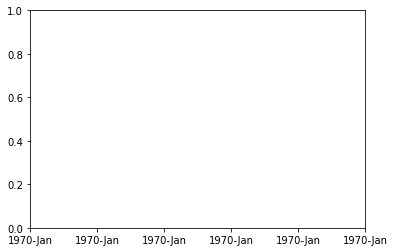

In [13]:
# should plot a timeseries
# throws a TypeError instead
fig1, ax1 = plt.subplots()
date_form = DateFormatter('%Y-%b')
ax1.xaxis.set_major_formatter(date_form)

for site, anarray in dailydepth['depth']:
    anarray.plot(ax=ax1,
                 color=color_dict1[site],
                 label=site)
plt.legend(loc='center_left', bbox_to_anchor=(1, 0.5))

In [ ]:
for site in sitecodes:
    startDate_SD = depths.loc[depths['date_time_utc']==depths['date_time_utc'].min(), 'depth']
    endDate_SD = depths.loc[depths['date_time_utc']==depths['date_time_utc'].max(), 'depth']
    sd_diff = endDate_SD - startDate_SD
    data = [site, startDate_SD, endDate_SD, sd_diff]

In [ ]:
endDate_SD = values_df.loc[values_df['date_time_utc']== values_df['date_time_utc'].max(),'value'].iloc[0]
print(endDate_SD)

In [ ]:
startDate_SD = values_df.loc[values_df['date_time_utc']== values_df['date_time_utc'].min(),'value'].iloc[0]
print(startDate_SD)

In [ ]:
endDate_SD - startDate_SD